## Analysis of stratified drug response

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot as up

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

### Load results and look at overall performance

In [3]:
# analysis of results generated by script:
# 01_stratified_classification/run_stratified_classification.py
# (with varying feature_selection parameters)

results_dir = os.path.join('results', 'drug_response_stratified')

n_dims = [100, 250, 500, 1000, 5000]

fs_methods = [
    'mad',
    'pancan_f_test',
    'median_f_test',
    'random'
]

# metric to plot results for
metric = 'aupr'
delta_metric = 'delta_{}'.format(metric)

In [8]:
results_df = au.load_prediction_results_fs(results_dir, cfg.fs_methods)

for n in n_dims:
    for fs_method in fs_methods:
        results_df.loc[
            (results_df.fs_method == fs_method) & 
            (results_df.n_dims == n),
            'fs_method'
        ] = '{}.{}'.format(fs_method, n)

results_df = (results_df
  .drop(columns=['holdout_cancer_type'])
  .rename(columns={'gene': 'drug'})
)

print(results_df.shape)
print(results_df.fs_method.unique())
print(results_df.n_dims.unique())
results_df.head()

(5760, 9)
['random.5000' 'mad.500' 'pancan_f_test.100' 'pancan_f_test.1000'
 'random.250' 'mad.5000' 'pancan_f_test.5000' 'mad.250' 'mad.100'
 'pancan_f_test.250' 'random.500' 'random.100' 'pancan_f_test.500'
 'mad.1000' 'random.1000' 'median_f_test.5000' 'median_f_test.1000'
 'median_f_test.250' 'median_f_test.100' 'median_f_test.500']
[5000  500  100 1000  250]


,auroc,aupr,drug,signal,seed,data_type,fold,fs_method,n_dims
0,0.85325,0.66493,Erlotinib,signal,42,train,0,random.5000,5000
1,0.60465,0.41320,Erlotinib,signal,42,test,0,random.5000,5000
2,0.66863,0.46217,Erlotinib,signal,42,cv,0,random.5000,5000
3,0.95121,0.81969,Erlotinib,signal,42,train,1,random.5000,5000
4,0.82114,0.64513,Erlotinib,signal,42,test,1,random.5000,5000


In [9]:
# get difference between true and shuffled models, split by
# feature selection method
def compare_from_experiment(experiment_df):
    compare_df = []
    for fs_method in experiment_df.fs_method.unique():
        compare_df.append(
            au.compare_control_ind(
                experiment_df[
                    (experiment_df.fs_method == fs_method)
                ], identifier='drug', metric=metric, verbose=True)
              .assign(fs_method=fs_method)
        )
    return pd.concat(compare_df)

compare_df = compare_from_experiment(results_df)

print(compare_df.shape)
compare_df.head()

(960, 5)


,identifier,seed,fold,delta_aupr,fs_method
0,Cetuximab,42,0,0.15029,random.5000
1,Cetuximab,42,1,0.10853,random.5000
2,Cetuximab,42,2,-0.02208,random.5000
3,Cetuximab,42,3,0.17483,random.5000
4,Cetuximab,1,0,0.11736,random.5000


In [10]:
compare_df[['fs_method', 'n_dims']] = compare_df.fs_method.str.split('.', 1, expand=True)
compare_df['n_dims'] = compare_df.n_dims.astype(int)

print(compare_df.fs_method.unique())
print(compare_df.n_dims.unique())
compare_df.head()

['random' 'mad' 'pancan_f_test' 'median_f_test']
[5000  500  100 1000  250]


,identifier,seed,fold,delta_aupr,fs_method,n_dims
0,Cetuximab,42,0,0.15029,random,5000
1,Cetuximab,42,1,0.10853,random,5000
2,Cetuximab,42,2,-0.02208,random,5000
3,Cetuximab,42,3,0.17483,random,5000
4,Cetuximab,1,0,0.11736,random,5000


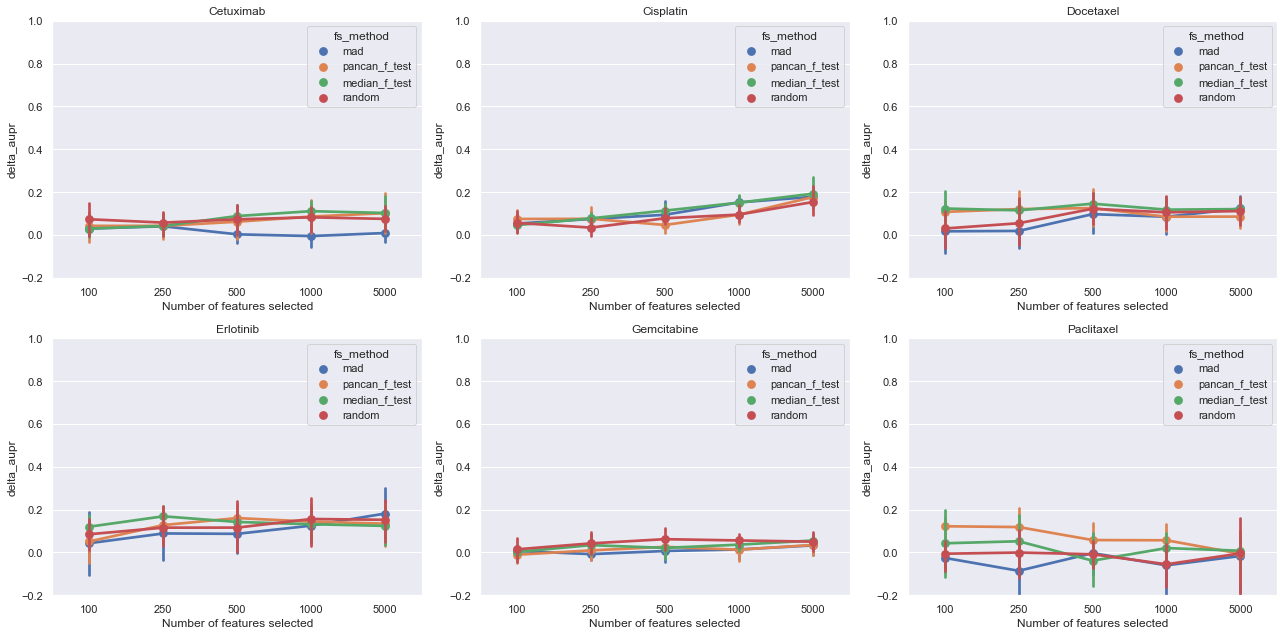

In [11]:
sns.set({'figure.figsize': (18, 9)})
sns.set_context('notebook')

fig, axarr = plt.subplots(2, 3)

fs_method_order = [
    'mad',
    'pancan_f_test',
    'median_f_test',
    'random'
]

for ix, drug in enumerate(compare_df.identifier.unique()):
    ax = axarr[ix // 3, ix % 3]
    plot_df = compare_df[compare_df.identifier == drug]
    sns.pointplot(data=plot_df, x='n_dims', y='delta_aupr',
                  hue='fs_method', hue_order=fs_method_order, ax=ax)
    ax.set_title(drug)
    ax.set_xlabel('Number of features selected')
    ax.set_ylim(-0.2, 1)

plt.tight_layout()

blah blah